In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
import yfinance

from rfcorr.random_forest import get_corr, get_pairwise_corr

In [2]:
rs = numpy.random.RandomState(42)

In [3]:
# fetch all symbols
symbol_list = ["SPY",
              "XLB",
              "XLE",
              "XLF",
               "XLI",
               "XLK",
               "XLP",
               "XLU",
               "XLV",
               "XLRE",
              ]

symbol_df = yfinance.download(symbol_list, progress=False)
symbol_df = symbol_df.dropna(axis=0)
print(symbol_df.shape)

(1600, 60)


In [4]:
close_close_ret_df = numpy.log(symbol_df.loc[:, "Adj Close"]).diff().iloc[1:]
close_close_ret_df.tail()

,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV
Date,,,,,,,,,,
2022-02-08,0.008194,0.015357,-0.021731,0.013827,0.009932,0.012287,0.003807,-0.009034,0.000731,0.008144
2022-02-09,0.014530,0.021554,0.008313,0.006355,0.013643,0.021938,0.000262,0.023912,0.004375,0.007706
2022-02-10,-0.018129,-0.005843,-0.006265,-0.008811,-0.016513,-0.026497,-0.010800,-0.028895,-0.025643,-0.015774
2022-02-11,-0.019916,-0.015592,0.028670,-0.014111,-0.015380,-0.031020,-0.003582,-0.013775,0.000597,-0.013952
2022-02-14,-0.003275,-0.008248,-0.023859,-0.011283,-0.003731,-0.000323,-0.002795,-0.010847,-0.008540,-0.010264


In [5]:
window = 20
start_date = pandas.Timestamp(datetime.date(2021, 1, 1))
start_date_index = [i for i, ix in enumerate(close_close_ret_df.index)
                    if ix >= start_date]
if len(start_date_index) > 0:
    start_date_index = start_date_index[0]
    if start_date_index <= window:
        raise ValueError("start_date and window are not compatible")
else:
    raise ValueError("start_date and data are not compatible")

window_corr_ts_list = []
window_corr_ts_index = []

for window_df in close_close_ret_df.iloc[(start_date_index - window):].rolling(window=window):
    if window_df.shape[0] == window:
        window_corr_ts_list.append(pandas.DataFrame(get_pairwise_corr(window_df.values,
                                                         num_trees=100,
                                                         lag=1, 
                                                         method="regression",
                                                         random_state=rs),
                                                columns=close_close_ret_df.columns,
                                                index=close_close_ret_df.columns))
        window_corr_ts_index.append(window_df.index[-1])

window_corr_ts_array = numpy.stack(window_corr_ts_list)
print(window_corr_ts_array.shape)

(283, 10, 10)


<AxesSubplot:title={'center':'Sector - SPY "rfcorr" time series (method=regression, window=20, lag=1)'}, xlabel='Date', ylabel='Correlation'>

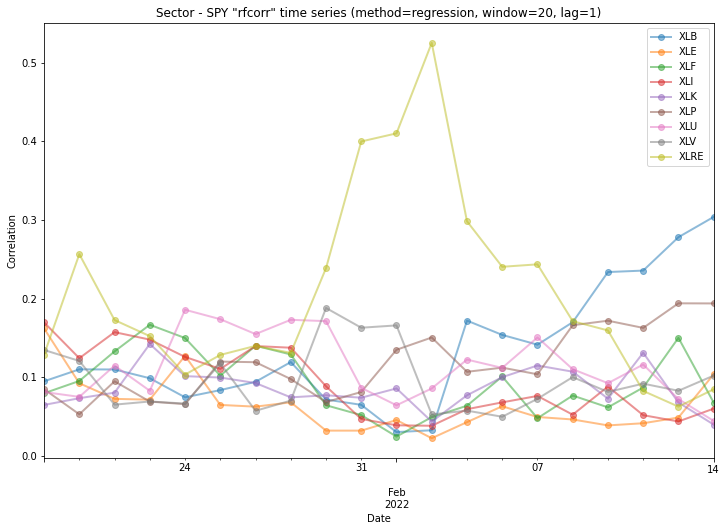

In [10]:
spy_index = symbol_list.index("SPY")
spy_corr_ts = pandas.DataFrame(window_corr_ts_array[:, spy_index, :], 
                 columns=symbol_list,
                 index=window_corr_ts_index)\
    .drop("SPY", axis=1)

f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title("Sector - SPY \"rfcorr\" time series (method=regression, window=20, lag=1)")
ax.set_ylabel("Correlation")
ax.set_xlabel("Date")
spy_corr_ts.tail(20).plot(ax=ax, linewidth=2, alpha=0.5, marker="o")

<AxesSubplot:title={'center':'SPY - Sector "rfcorr" time series (method=regression, window=20, lag=1)'}, xlabel='Date', ylabel='Correlation'>

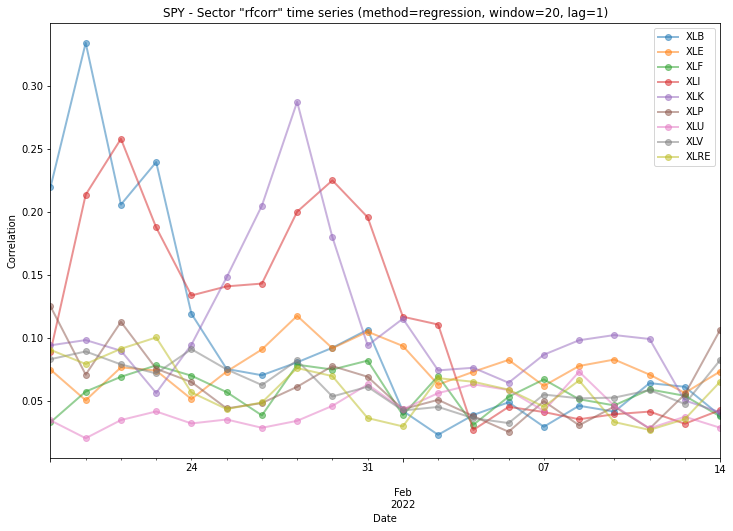

In [11]:
spy_index = symbol_list.index("SPY")
spy_corr_ts = pandas.DataFrame(window_corr_ts_array[:, :, spy_index], 
                 columns=symbol_list,
                 index=window_corr_ts_index)\
    .drop("SPY", axis=1)

f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title("SPY - Sector \"rfcorr\" time series (method=regression, window=20, lag=1)")
ax.set_ylabel("Correlation")
ax.set_xlabel("Date")
spy_corr_ts.tail(20).plot(ax=ax, linewidth=2, alpha=0.5, marker="o")